In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torchvision import datasets, transforms

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

## Task 1.3 - 1.1

In [9]:
class SimpleNetwork1(nn.Module):
    def __init__(self):
        super(SimpleNetwork1, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view(-1, 784)  
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)
        return x

# Instantiate the network
SimpleNet1 = SimpleNetwork1().to(device)

In [10]:
class SimpleNetwork2(nn.Module):
    def __init__(self):
        super(SimpleNetwork2, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view(-1, 784)  
        x = F.sigmoid(self.fc1(x))  
        x = self.fc2(x)
        return x

# Instantiate the network
SimpleNet2 = SimpleNetwork2().to(device)

In [11]:
batch_size = 64
np.random.seed(0)
torch.manual_seed(0)
transform = transforms.Compose([transforms.ToTensor()])
permutation = torch.randperm(28 * 28)

train_dataset = datasets.ImageFolder('../data/MNIST/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.ImageFolder('../data/MNIST/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

def permute_images(dataset, permutation):
    permuted_dataset = []
    for image, label in dataset:
        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        # ax1.imshow(image.permute(1,2,0))
        permuted_image = image.view(-1, 28*28)[:, permutation].view_as(image)
        # ax2.imshow(permuted_image.permute(1,2,0))
        permuted_dataset.append((permuted_image, label))
        # break
    return permuted_dataset

permuted_train_dataset = permute_images(train_dataset, permutation)
permuted_test_dataset = permute_images(test_dataset, permutation)
permuted_train_loader = DataLoader(permuted_train_dataset, batch_size=batch_size, shuffle=True)
permuted_test_loader = DataLoader(permuted_test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def train_and_plot(network, train_loader, test_loader, epochs=50, lr=1e-2, momentum=0.9, gamma=0.9):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    epoch_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        network.train()  
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        scheduler.step()

        # eval mode
        network.eval()  
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = network(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        average_test_loss = test_loss / len(test_loader)
        test_losses.append(average_test_loss)
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

    # Print the final results
    print(f"Finished Training\nParameters: {sum(p.numel() for p in network.parameters())}")
    print(f"Final Training Loss: {epoch_losses[-1]:.4f}")
    print(f"Final Test Loss: {test_losses[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

    # Plotting Training and Test Losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return epoch_losses, test_losses, test_accuracies, network

Simple Net 1: ReLU


100%|███████████████████████████████████████████| 50/50 [02:10<00:00,  2.61s/it]

Finished Training
Parameters: 795010
Final Training Loss: 0.0394
Final Test Loss: 0.0677
Final Test Accuracy: 97.88%


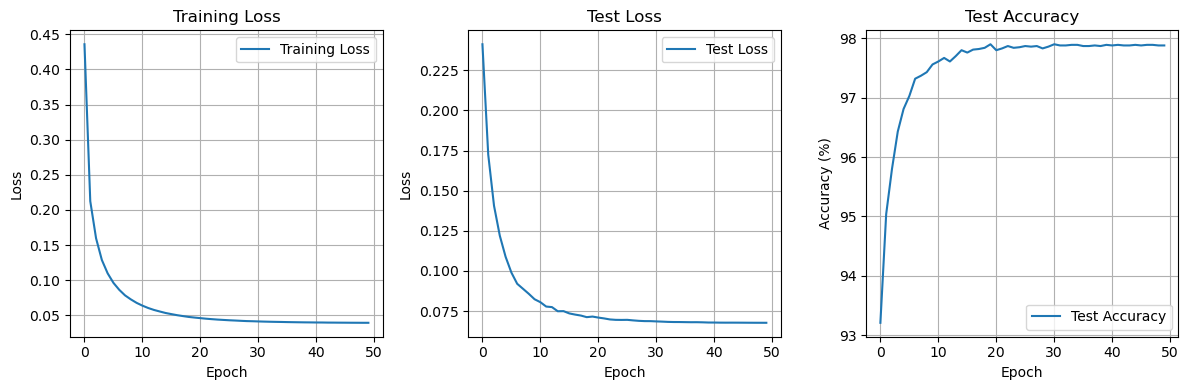

Simple Net 1: Sigmoid


100%|███████████████████████████████████████████| 50/50 [02:12<00:00,  2.65s/it]

Finished Training
Parameters: 795010
Final Training Loss: 0.2550
Final Test Loss: 0.2565
Final Test Accuracy: 92.61%


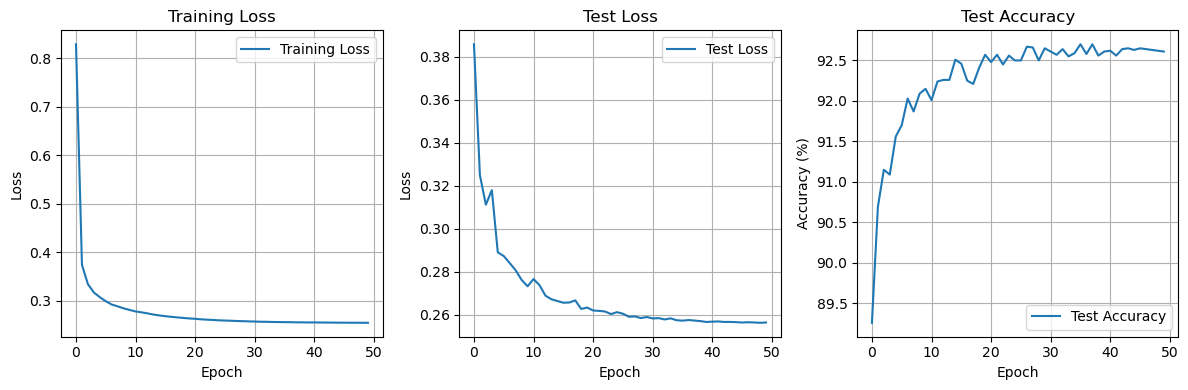

In [7]:
print("Simple Net 1: ReLU")
training_losses1, testing_losses1, acc1, network1 = train_and_plot(SimpleNet1, permuted_train_loader, permuted_test_loader)
print("Simple Net 1: Sigmoid")
training_losses2, testing_losses2, acc2, network2 = train_and_plot(SimpleNet2, permuted_train_loader, permuted_test_loader)

## Task 1.3 - 1.2

In [8]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(26*26, 1000)  
        self.fc2 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 26*26)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_network1 = CNN1().to(device)

In [9]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(26*26, 1000)  
        self.fc2 = nn.Linear(1000, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 26*26)
        x = self.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

conv_network2 = CNN2().to(device)

Conv Net 1: ReLU


100%|███████████████████████████████████████████| 50/50 [02:45<00:00,  3.31s/it]

Finished Training
Parameters: 687020
Final Training Loss: 0.0015
Final Test Loss: 0.0631
Final Test Accuracy: 98.29%


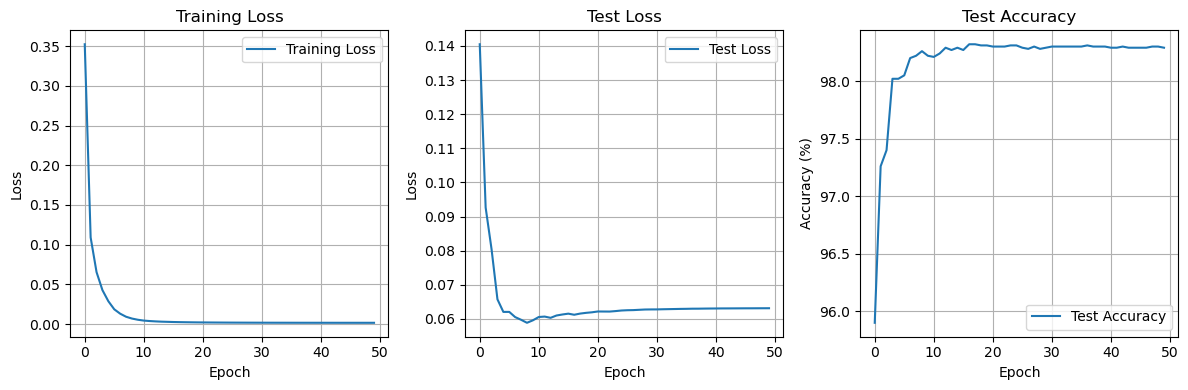

Conv Net 2: Sigmoid


100%|███████████████████████████████████████████| 50/50 [02:44<00:00,  3.29s/it]

Finished Training
Parameters: 687020
Final Training Loss: 0.0231
Final Test Loss: 0.0630
Final Test Accuracy: 98.05%


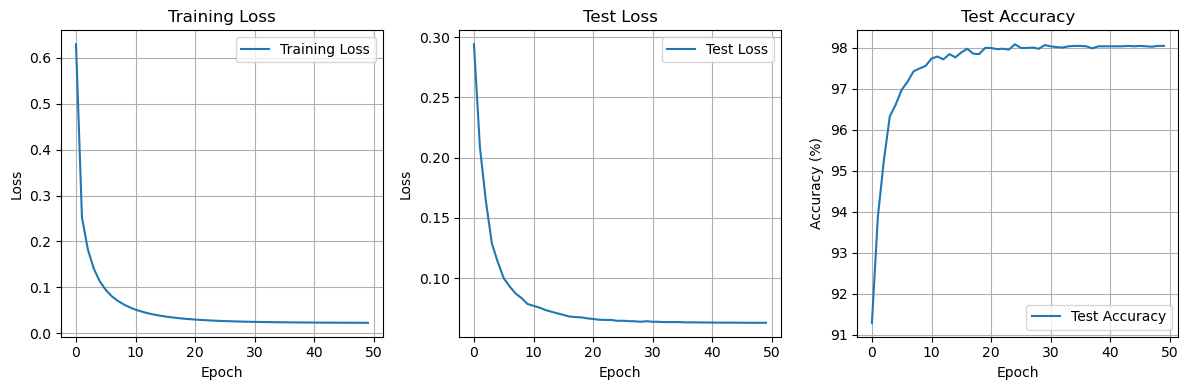

In [10]:
print("Conv Net 1: ReLU")
cnn_training_losses1, cnn_testing_losses1, cnn_acc1, cnn_network1 = train_and_plot(conv_network1, permuted_train_loader, permuted_test_loader)
print("Conv Net 2: Sigmoid")
cnn_training_losses2, cnn_testing_losses2, cnn_acc2, cnn_network2 = train_and_plot(conv_network2, permuted_train_loader, permuted_test_loader)

Q: Did you observe an increase in classification accuracy?

A: Classification accuracy is increased in both relu and sigmoid activation when convolutional filters are applied. It can be seen that using ReLU as an activation function is slightly better than using a sigmoid. This is because ReLU can overcome the issue of sigmoid: vanishing gradient and saturation

In [11]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(3, stride=3)
        self.fc1 = nn.Linear(8*8, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(-1, 8*8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_network3 = CNN3().to(device)

In [12]:
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(3, stride=3)
        self.fc1 = nn.Linear(8*8, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(-1, 8*8)
        x = self.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

conv_network4 = CNN4().to(device)

Conv Net 3: ReLU


100%|███████████████████████████████████████████| 50/50 [02:50<00:00,  3.40s/it]

Finished Training
Parameters: 75020
Final Training Loss: 0.0206
Final Test Loss: 0.2014
Final Test Accuracy: 94.35%


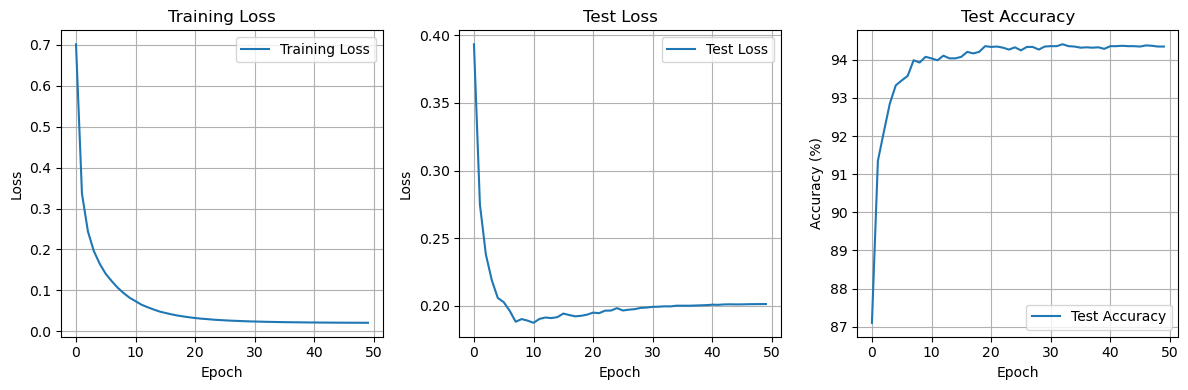

Conv Net 4: Sigmoid


100%|███████████████████████████████████████████| 50/50 [02:50<00:00,  3.42s/it]

Finished Training
Parameters: 75020
Final Training Loss: 0.1335
Final Test Loss: 0.1876
Final Test Accuracy: 94.10%


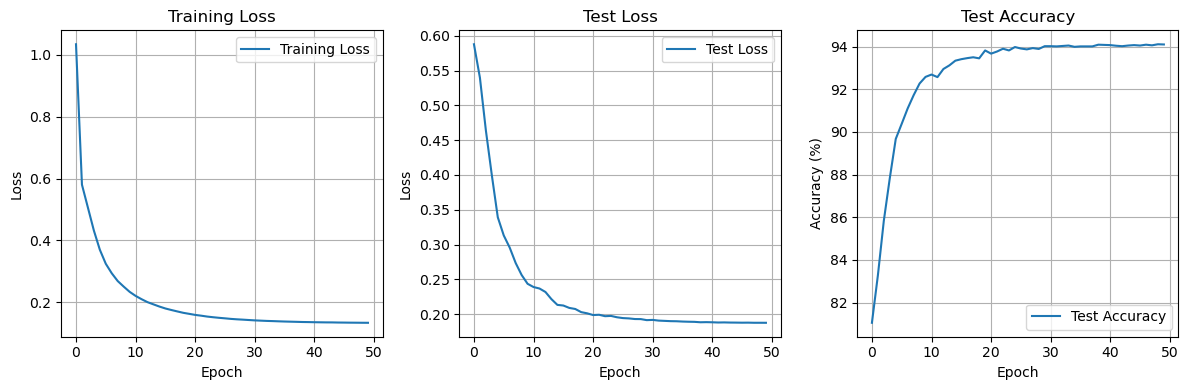

In [13]:
print("Conv Net 3: ReLU")
cnn_maxpool_training_losses1, cnn_maxpool_testing_losses1, cnn_maxpool_acc1, cnn_mp_network1 = train_and_plot(conv_network3, permuted_train_loader, permuted_test_loader)
print("Conv Net 4: Sigmoid")
cnn_maxpool_training_losses2, cnn_maxpool_testing_losses2, cnn_maxpool_acc2, cnn_mp_network2 = train_and_plot(conv_network4, permuted_train_loader, permuted_test_loader)

shape of cnn output: (26, 26, 1)
shape of cnn with maxpool output: (8, 8, 1)
shape of original image: (28, 28, 1)
label: 7


Text(0.5, 1.0, 'Original Image')

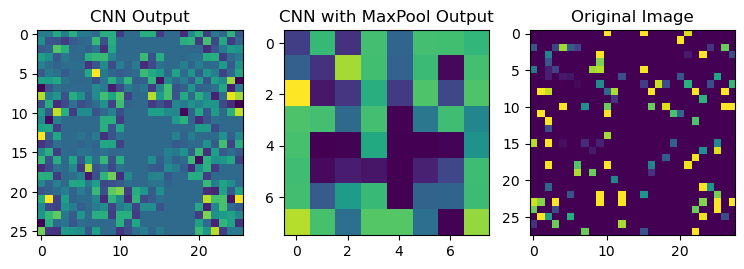

In [14]:
images, labels = next(iter(permuted_test_loader))

# cnn 
cnn_output_relu = cnn_network1.conv1(images[0].to(device)).permute(1, 2, 0).cpu().detach().numpy()
print("shape of cnn output:", cnn_output_relu.shape)

# cnn with maxpool
cnn_maxpool_relu = cnn_mp_network1.conv1(images[0].to(device))
cnn_maxpool_relu = cnn_mp_network1.pool(cnn_maxpool_relu).permute(1, 2, 0).cpu().detach().numpy()
print("shape of cnn with maxpool output:", cnn_maxpool_relu.shape)

# orignal image 
image = images[0].permute(1, 2, 0).cpu().detach().numpy()
label = labels[0]
print("shape of original image:", image.shape)
print("label:", label.item())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
ax1.imshow(cnn_output_relu)
ax2.imshow(cnn_maxpool_relu)
ax3.imshow(image)

ax1.set_title("CNN Output")
ax2.set_title("CNN with MaxPool Output")
ax3.set_title("Original Image")

Q: Comment on your observations. To answer this, you may want to plot the outputs of the convolution layer or convolution+max-pool layers as an image and compare them with the input image.

A: By observing 'CNN' and 'CNN with Maxpool output', it can be seen that the CNN correctly captures the image feature but their pattern is quite vague. Classification accuracy is decreased in both relu and sigmoid activation when max pooling is applied in combination with a convolutional filter. Normally, when max pooling is applied with a convolutional filter, it outputs better performance. However, in this case, the performance has been degraded. This is primarily due to the significantly low number of neurons at the fully connected layer as we have applied max-pooling. There are only 8x8 pixels that a fully connected layer could play with. This is a significant loss of information considering that there are 26x26 pixels available in a convolutional filter.

Q: Repeat Tasks 1.1 and 1.2 on the permuted dataset. Does the performance of Task 1.1 change after the permutation? Does the performance of Task 1.2 change after the permutation? Can you explain your answers?

A: 
- For task 1.1 where we use only a fully connected layer, there is no big difference between the normal dataset and the permuted dataset. The training with the normal dataset acquires slightly better performance than the permuted dataset.
- For task 1.2 (convolutional filter only) when using a convolutional filter only, again, there is no big difference. The normal dataset's performance is slightly better than the permuted dataset's performance. 
- For task 1.2 (convolutional filter with max pooling) when using a convolutional filter with max-pooling, there is a bigger difference in comparison to tasks 1.1 and 1.2. The normal dataset's performance is more than slightly better than the permuted dataset's performance. It looks like the pooling layer is not able to capture the essence of the features in the permuted images effectively. This can be observed by comparing the activation maps of normal dataset 'CNN with MaxPool Output' and permuted dataset 'CNN with MaxPool Output'.